In [357]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
from multiprocessing import Pool
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from torchvision import transforms, models
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import cohen_kappa_score
import timm
import copy



In [358]:
## for removing file if required
import shutil

try:
    shutil.rmtree("/kaggle/working/train")
    
    model_file_to_delete ="/kaggle/working/models"

    if os.path.isfile(model_file_to_delete):
        os.remove(model_file_to_delete)
    
except:
    print("No such directories")

# Explatory Data Analysis
## Load Data

In [359]:
def load_data(data_dir):
    train_csv = os.path.join(data_dir, 'train.csv')
    test_csv = os.path.join(data_dir, 'test.csv')
    
    train = pd.read_csv(train_csv)
    test = pd.read_csv(test_csv)
    
    train_dir = os.path.join(data_dir, 'train_images/')
    test_dir = os.path.join(data_dir, 'test_images/')
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir, '{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir, '{}.png'.format(x)))
    
    train['file_name'] = train["id_code"] + ".png"
    test['file_name'] = test["id_code"] + ".png"
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train, test

In [360]:
data_dir = '/kaggle/input/aptos2019-blindness-detection/'
train_df, test_df = load_data(data_dir)

## Data Shape, Distribution & Visualization

### shape

In [361]:
print(train_df.shape)
train_df.head()

(3662, 4)


,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,/kaggle/input/aptos2019-blindness-detection/tr...,000c1434d8d7.png
1,001639a390f0,4,/kaggle/input/aptos2019-blindness-detection/tr...,001639a390f0.png
2,0024cdab0c1e,1,/kaggle/input/aptos2019-blindness-detection/tr...,0024cdab0c1e.png
3,002c21358ce6,0,/kaggle/input/aptos2019-blindness-detection/tr...,002c21358ce6.png
4,005b95c28852,0,/kaggle/input/aptos2019-blindness-detection/tr...,005b95c28852.png


In [362]:
print(test_df.shape)
test_df.head()

(1928, 3)


,id_code,file_path,file_name
0,0005cfc8afb6,/kaggle/input/aptos2019-blindness-detection/te...,0005cfc8afb6.png
1,003f0afdcd15,/kaggle/input/aptos2019-blindness-detection/te...,003f0afdcd15.png
2,006efc72b638,/kaggle/input/aptos2019-blindness-detection/te...,006efc72b638.png
3,00836aaacf06,/kaggle/input/aptos2019-blindness-detection/te...,00836aaacf06.png
4,009245722fa4,/kaggle/input/aptos2019-blindness-detection/te...,009245722fa4.png


### distribution

In [363]:
def plot_dis_classes(df):
    df_group = df['diagnosis'].value_counts().reset_index()
    df_group.columns = ['diagnosis', 'count']

    plt.figure(figsize=(10, 5))
    plt.bar(df_group['diagnosis'], df_group['count'], color='skyblue')
    plt.xlabel('Diagnosis')
    plt.ylabel('Count')
    plt.title('Output Class Distribution')
    plt.show()

diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64


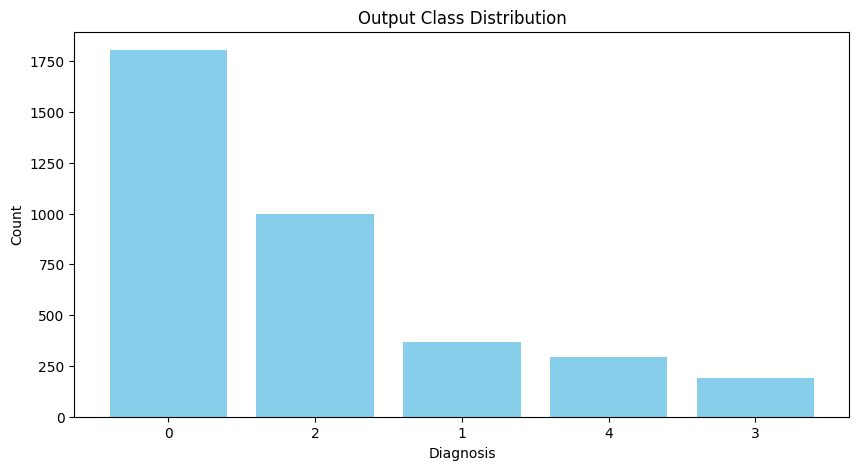

In [364]:
print(train_df['diagnosis'].value_counts())
plot_dis_classes(train_df)

#### Here we can see in the trainig images there is -
1. 1805 images of class 0 - No DR
2. 999 images of class 1 - Mild DR
3. 370 images of class 2 - Moderate DR
4. 295 images of class 3 - Severe DR, and
5. 193 images of class 4 - Proliferative DR

### visualization_function

In [365]:
def visualize_imgs(df, plots_per_class, color_scale, img_size):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(plots_per_class)).reset_index(drop=True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(plots_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (plots_per_class*0),pt + (plots_per_class*1), pt + (plots_per_class*2),pt + (plots_per_class*3),pt + (plots_per_class*4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = convert_to_gray(cv2.imread(df_temp.file_path.iloc[i]), img_size)
                axarr[i].imshow(img,cmap = color_scale)
            else: ## RGB
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((img_size,img_size)))
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

### Data Visulaization

/tmp/ipykernel_34/136394828.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(plots_per_class)).reset_index(drop=True)


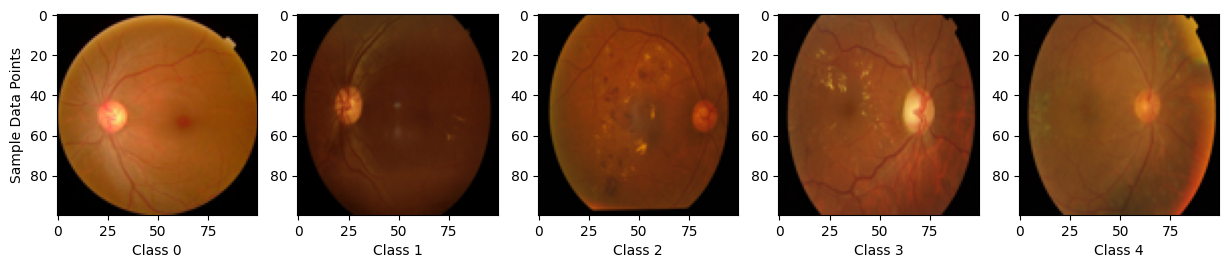

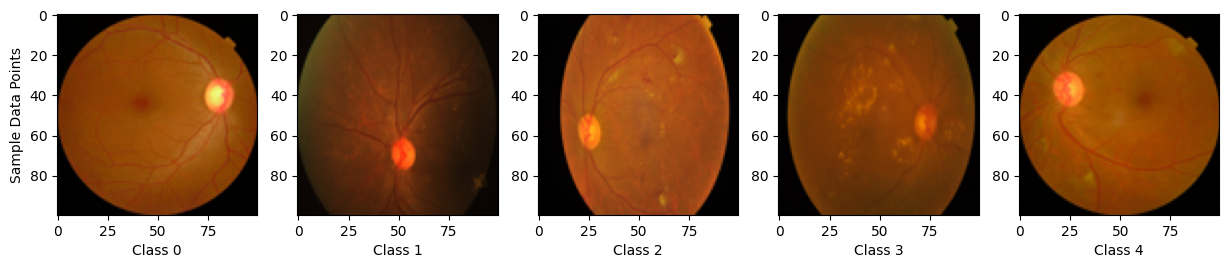

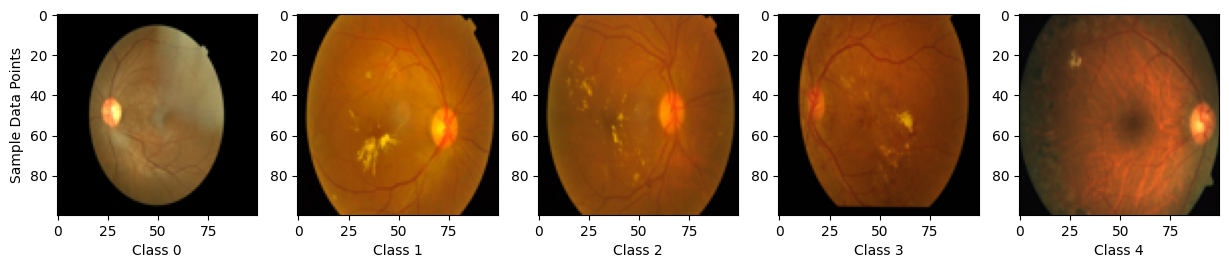

In [366]:
plots_per_class = 3
img_size = 100
visualize_imgs(train_df,plots_per_class,None, img_size)

#### As we can't differentiate much from this RGB images we will look into Grey Scale images for better differentiation.

In [367]:
## function to convert images into grey scale
def convert_to_gray(img, img_size):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (img_size,img_size))
    return img

/tmp/ipykernel_34/136394828.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(plots_per_class)).reset_index(drop=True)


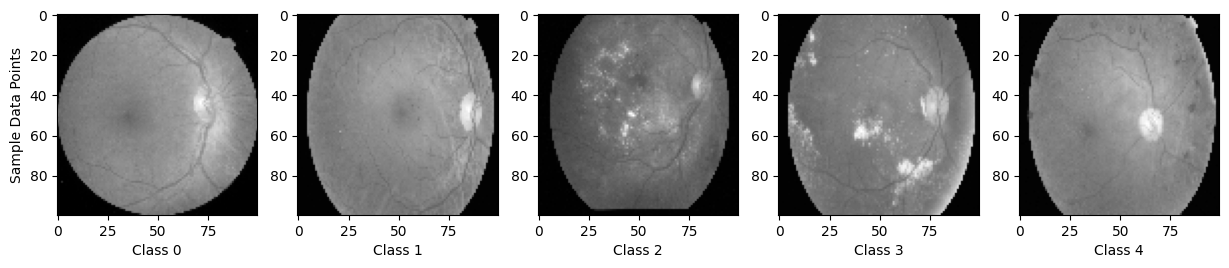

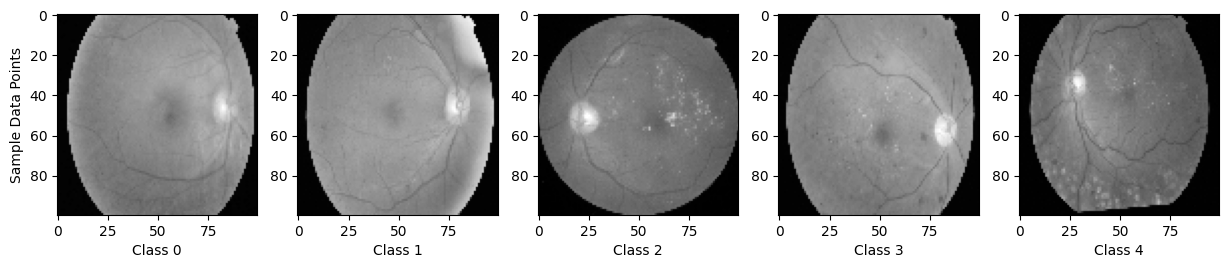

In [368]:
plots_per_class = 2
img_size = 100
visualize_imgs(train_df,plots_per_class,'gray',img_size)

#### Still we can't differentiate much here, so we have to explore for further pre-processing to differentiate between classes.

## Pre-Processing

#### Considering the pictures above we can see that the pictures are not uniforemly captured as technicians traveled to th rureal areas to capture images. Thus we can see there is non-uniforemd shape of the pictures.
#### So we try to remove those unnecessary black borders from the images and crop the image to take up the entirity of the image.

In [369]:
def crop_img(img, percentage):
    
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    
    threshold = img_gray > 0.1 * np.mean(img_gray[img_gray != 0])
    row_sums = np.sum(threshold, axis=1)
    col_sums = np.sum(threshold, axis=0)
    
    rows = np.where(row_sums > img_arr.shape[1] * percentage)[0]
    cols = np.where(col_sums > img_arr.shape[0] * percentage)[0]
    
    min_row, min_col = np.min(rows), np.min(cols)
    max_row, max_col = np.max(rows), np.max(cols)
    
    crop_img = img_arr[min_row : max_row + 1, min_col : max_col + 1]
    
    return Image.fromarray(crop_img)

In [370]:
def resize_maintain_aspect(img, desired_size):
    old_width, old_height = img.size
    aspect_ratio = old_width / old_height

    if aspect_ratio > 1:
        new_width = desired_size
        new_height = int(desired_size / aspect_ratio)
    else:
        new_height = desired_size
        new_width = int(desired_size * aspect_ratio)

    resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)
    
    padded_image = Image.new("RGB", (desired_size, desired_size))
    x_offset = (desired_size - new_width) // 2
    y_offset = (desired_size - new_height) // 2
    padded_image.paste(resized_img, (x_offset, y_offset))
    
    return padded_image

In [371]:
def save_single(args):
    image_path, output_path_folder, percentage, output_size = args
    image = Image.open(image_path)
    
    # Display the image
    #plt.imshow(image)
    #plt.title('Original Image')
    #plt.show()
    
    croped_img = crop_img(image,percentage)
    image_resized = resize_maintain_aspect(croped_img, desired_size=output_size[0])
    
    #print(output_path_folder)
    #print(image_path)
    output_image_path = os.path.basename(image_path)
    # Save the resized image
    output_file_path = os.path.join(output_path_folder, output_image_path)
    #print(output_file_path)
    image_resized.save(output_file_path)

In [372]:
def fast_image_resize(df, output_path_folder, percentage, output_size=None):
    """Uses multiprocessing to make it fast"""
    if not output_size:
        warnings.warn("Need to specify output_size! For example: output_size=100")
        return

    if not os.path.exists(output_path_folder):
        os.makedirs(output_path_folder)
        
    jobs = []
    for df_item in range(len(df)):
        image_path = df.file_path.iloc[df_item]
        #print(image_path)
        job = (image_path, output_path_folder, percentage, output_size)
        jobs.append(job)
    
    """
    results = []
    for job in tqdm(jobs, total=len(jobs)):
        result = save_single(job)
        results.append(result)
    """
    with Pool() as p:
        list(tqdm(p.imap_unordered(save_single, jobs), total=len(jobs)))

In [373]:
percentage = 0.01
fast_image_resize(train_df, "/kaggle/working/train/images_resized_150/",percentage, output_size=(100, 100))

  0%|          | 0/3662 [00:00<?, ?it/s]/tmp/ipykernel_34/3153832717.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)
  0%|          | 1/3662 [00:00<09:24,  6.48it/s]/tmp/ipykernel_34/3153832717.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)
  0%|          | 2/3662 [00:00<14:49,  4.12it/s]/tmp/ipykernel_34/3153832717.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)
/tmp/ipykernel_34/3153832717.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resam

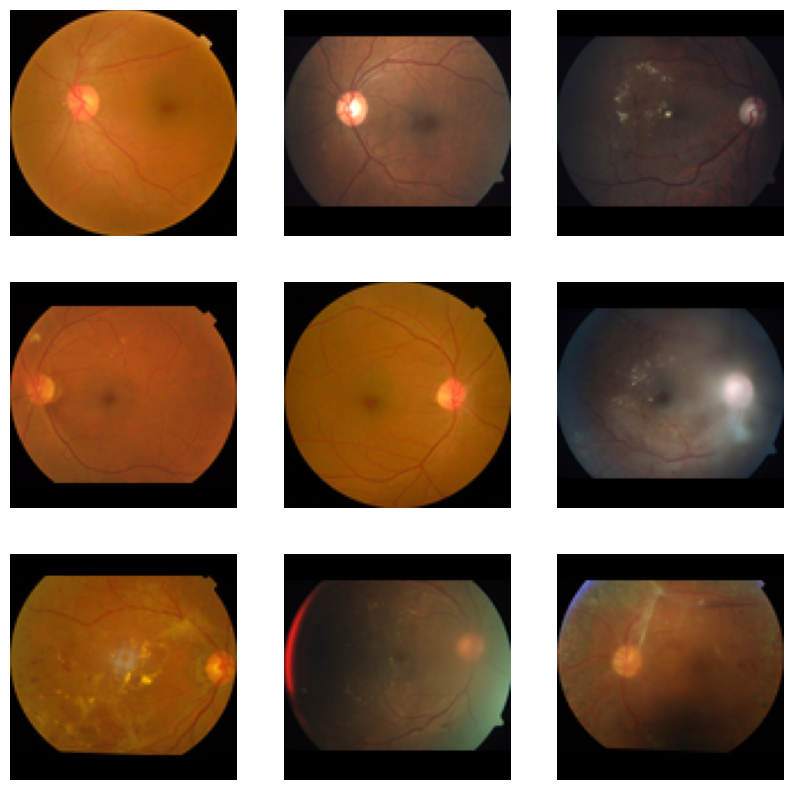

In [374]:
# Path to the directory containing the images
directory = "/kaggle/working/train/images_resized_150"

# Get a list of image filenames in the directory
image_files = os.listdir(directory)

# Define the number of images to display
num_images_to_display = 9

# Display the first few images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    # Check if there are more images to display
    if i < len(image_files):
        # Load the image
        img_path = os.path.join(directory, image_files[i])
        img = mpimg.imread(img_path)
        
        # Display the image
        ax.imshow(img)
        ax.axis('off')  # Hide axis
    else:
        # If there are no more images, remove the axis
        ax.axis('off')

plt.show()

## Model Implementation - Ensambling (ResNet18 & EfficientNet_b0)

In [375]:
class BlindnessDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, augmentations=None, max_count=None, test=False):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.augmentations = augmentations
        self.max_count = max_count
        self.test = test
        
        if not test:
            self.class_counts = self.annotations['diagnosis'].value_counts()
        else:
            self.class_counts = None
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0] + '.png')
        image = Image.open(img_name).convert('RGB')
        
        if self.test:
            if self.transform:
                image = self.transform(image)
            return image
        
        label = int(self.annotations.iloc[idx, 1])
        
        ## Applying augmentation for minority classes
        if self.class_counts[label] < self.max_count:
            if self.augmentations:
                image = self.augmentations(image)
        else:
            if self.transform:
                image = self.transform(image)
        
        return image, label

##### Augmentation

In [376]:
augmentations = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [377]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [378]:
csv_file = '/kaggle/input/aptos2019-blindness-detection/train.csv'
pros_img_dir = '/kaggle/working/train/images_resized_150'

In [379]:
## Loading the dataset for determination of the class counts
temp_dataset = BlindnessDataset(csv_file, pros_img_dir, transform=transform)
class_counts = temp_dataset.class_counts
max_count = class_counts.max()


In [380]:
dataset = BlindnessDataset(csv_file, pros_img_dir, transform=transform, augmentations=augmentations, max_count=max_count)

In [381]:
train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, stratify=dataset.annotations.iloc[:, 1])
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

In [382]:
def train_model(model, model_name):
    if model_name == 'efficientnet_b0':
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    elif model_name == 'resnet18':
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-3)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)



    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    def quadratic_weighted_kappa(y_true, y_pred):
        return cohen_kappa_score(y_true, y_pred, weights='quadratic')

    best_model_wts = copy.deepcopy(model.state_dict())
    best_kappa = 0.0
    patience = 3
    counter = 0

    val_predictions = []
    val_labels = []

    for epoch in range(13):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")
        
        # Validation
        model.eval()
        val_preds = []
        val_labels_epoch = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_labels_epoch.extend(labels.cpu().numpy())
        
        val_predictions.append(val_preds)
        val_labels.append(val_labels_epoch)
        
        kappa = quadratic_weighted_kappa(val_labels_epoch, val_preds)
        print(f"Validation QWK: {kappa}")
        
        """
        # Early stopping
        if kappa > best_kappa:
            best_kappa = kappa
            best_model_wts = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                break
        """
        if kappa > best_kappa:
            best_kappa = kappa
            best_model_wts = copy.deepcopy(model.state_dict())
        # Step the learning rate scheduler
        scheduler.step()

    print(f"Best Validation QWK for {model_name}: {best_kappa}")

    model.load_state_dict(best_model_wts)

    model_save_path = f'{model_name}_aptos.pth'
    torch.save(model.state_dict(), model_save_path)

    return val_predictions, val_labels

In [383]:
efficientnet_model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=5)
print("Training EfficientNet_b0...")
effnet_val_predictions, effnet_val_labels = train_model(efficientnet_model, 'efficientnet_b0')
print("Finished training EfficientNet_b0")


Training EfficientNet_b0...
Epoch 1, Loss: 0.884567198060129
Validation QWK: 0.8046696373554202
Epoch 2, Loss: 0.6172551098077194
Validation QWK: 0.854021778750872
Epoch 3, Loss: 0.5858285028649413
Validation QWK: 0.8230305126971718
Epoch 4, Loss: 0.5327352142852285
Validation QWK: 0.8530327703453887
Epoch 5, Loss: 0.5155121978858243
Validation QWK: 0.8265651674736685
Epoch 6, Loss: 0.46469566080233327
Validation QWK: 0.8825551020849048
Epoch 7, Loss: 0.44099900045472645
Validation QWK: 0.892403247251018
Epoch 8, Loss: 0.4215830026761345
Validation QWK: 0.8834736759412584
Epoch 9, Loss: 0.40499824228818004
Validation QWK: 0.8948026111545129
Epoch 10, Loss: 0.40555558952948323
Validation QWK: 0.8715222295187456
Epoch 11, Loss: 0.39154469286618027
Validation QWK: 0.903073839016475
Epoch 12, Loss: 0.3930973532083242
Validation QWK: 0.8960999514012635
Epoch 13, Loss: 0.3747039518278578
Validation QWK: 0.8996771641348443
Best Validation QWK for efficientnet_b0: 0.903073839016475
Finished tr

In [384]:
resnet_model = models.resnet18(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 5)
print("Training ResNet18...")
resnet_val_predictions, resnet_val_labels = train_model(resnet_model, 'resnet18')
print("Finished training ResNet18")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training ResNet18...
Epoch 1, Loss: 0.7095907842335494
Validation QWK: 0.8087694632808977
Epoch 2, Loss: 0.6380158873355907
Validation QWK: 0.14763700589455864
Epoch 3, Loss: 0.6411639911972958
Validation QWK: 0.819437323917908
Epoch 4, Loss: 0.6140117243580197
Validation QWK: 0.8148845086970188
Epoch 5, Loss: 0.6335354551025059
Validation QWK: 0.8034824394267155
Epoch 6, Loss: 0.6143646920504777
Validation QWK: 0.8156780288651327
Epoch 7, Loss: 0.6053928246964579
Validation QWK: 0.8215992901175622
Epoch 8, Loss: 0.6054954924013304
Validation QWK: 0.8211309071687177
Epoch 9, Loss: 0.6032029889200045
Validation QWK: 0.8183571876463227
Epoch 10, Loss: 0.6005985471217529
Validation QWK: 0.8250713363644554
Epoch 11, Loss: 0.5974587454744007
Validation QWK: 0.8243242498705249
Epoch 12, Loss: 0.5999051607821299
Validation QWK: 0.8195676843169858
Epoch 13, Loss: 0.5956204018515089
Validation QWK: 0.8270364435106092
Best Validation QWK for resnet18: 0.8270364435106092
Finished training ResNet1

In [400]:
def ensemble_predictions(effnet_predictions, resnet_predictions):

    combined_stacked = np.stack((effnet_predictions, resnet_predictions), axis=0)
    mean_predictions = np.mean(combined_stacked, axis=0)
    final_predictions = np.argmax(mean_predictions, axis=1)
    
    return final_predictions

### Ensamble Evaluation

In [408]:
num_samples = len(val_indices)
val_labels = [dataset.annotations.iloc[i, 1] for i in val_indices]
num_classes = len(np.unique(val_labels))

ensemble_val_predictions = ensemble_predictions(effnet_val_predictions, resnet_val_predictions)

effnet_val_labels = np.array(effnet_val_labels).flatten()
resnet_val_labels = np.array(resnet_val_labels).flatten()

assert len(effnet_val_labels) == len(resnet_val_labels)
assert len(effnet_val_labels) == len(ensemble_val_predictions)

# Calculating final kappa score on validation data
final_kappa = cohen_kappa_score(effnet_val_labels, ensemble_val_predictions, weights='quadratic')
print(f"Final Ensemble Validation QWK: {final_kappa}")

Final Ensemble Validation QWK: 0.07831626757603172


In [403]:
# Generate test set predictions using the ensemble
test_csv_file = '/kaggle/input/aptos2019-blindness-detection/test.csv'
test_root_dir = '/kaggle/input/aptos2019-blindness-detection/test_images'
test_dataset = BlindnessDataset(test_csv_file, test_root_dir, transform=transform, test=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [404]:
def load_model(model_name, model_type):
    if model_type == 'efficientnet_b0':
        model = timm.create_model(model_name, pretrained=False, num_classes=5)
    elif model_type == 'resnet18':
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, 5)
    
    model.load_state_dict(torch.load(f'{model_name}_aptos.pth'))
    model.to(device)
    model.eval()
    return model

In [405]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_model = load_model('efficientnet_b0', 'efficientnet_b0')
resnet_model = load_model('resnet18', 'resnet18')

ensemble_test_predictions = []

with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        effnet_outputs = efficientnet_model(images)
        resnet_outputs = resnet_model(images)
        
        outputs = torch.stack([effnet_outputs, resnet_outputs])
        mean_outputs = torch.mean(outputs, dim=0)
        _, predicted = torch.max(mean_outputs, 1)
        ensemble_test_predictions.extend(predicted.cpu().numpy())

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [406]:
submission_df = pd.DataFrame({'id_code': pd.read_csv(test_csv_file)['id_code'], 'diagnosis': ensemble_test_predictions})
submission_df.to_csv('submission.csv', index=False)